In [1]:
import torch
import torch.nn as nn
from torch.utils import data
from mds189 import Mds189
import numpy as np
from skimage import io, transform
import ipdb
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import torchvision.models as models
from PIL import Image
import time
start = time.time()

In [2]:
import torch
print(torch.__version__)

1.0.1.post2


In [3]:
# Helper functions for loading images.
def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

def accimage_loader(path):
    import accimage
    try:
        return accimage.Image(path)
    except IOError:
        # Potentially a decoding problem, fall back to PIL.Image
        return pil_loader(path)

def default_loader(path):
    from torchvision import get_image_backend
    if get_image_backend() == 'accimage':
        return accimage_loader(path)
    else:
        return pil_loader(path)


In [47]:
# flag for whether you're training or not
is_train = True
is_key_frame = True # TODO: set this to false to train on the video frames, instead of the key frames
model_to_load = 'model.ckpt' # This is the model to load during testing, if you want to eval a previously-trained model.

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
#cudnn.benchmark = True

# Parameters for data loader
params = {'batch_size': 64,  # TODO: fill in the batch size. often, these are things like 32,64,128,or 256
          'shuffle': True,
          'num_workers': 30 
          }

In [48]:


# TODO: Hyper-parameters
num_epochs = 15
learning_rate = 0.0001
# NOTE: depending on your optimizer, you may want to tune other hyperparameters as well

# Datasets
# TODO: put the path to your train, test, validation txt files
if is_key_frame:
    label_file_train =  './data/keyframe_data_train.txt'
    label_file_val  =  './data/keyframe_data_val.txt'
    # NOTE: the kaggle competition test data is only for the video frames, not the key frames
    # this is why we don't have an equivalent label_file_test with keyframes
else:
    label_file_train = './data/videoframe_data_train.txt'
    label_file_val = './data/videoframe_data_val.txt'
    label_file_test = './data/videoframe_data_test.txt'

# TODO: you should normalize based on the average image in the training set. This shows 
# an example of doing normalization
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]
# TODO: if you want to pad or resize your images, you can put the parameters for that below.

# Generators
# NOTE: if you don't want to pad or resize your images, you should delete the Pad and Resize
# transforms from all three _dataset definitions.
train_dataset = Mds189(label_file_train,loader=default_loader,transform=transforms.Compose([
                                               #transforms.Pad(1),    # TODO: if you want to pad your images
                                               #transforms.Resize(256), # TODO: if you want to resize your images
                                               transforms.ToTensor(),
                                               transforms.Normalize(mean, std)
                                           ]))
train_loader = data.DataLoader(train_dataset, **params)

val_dataset = Mds189(label_file_val,loader=default_loader,transform=transforms.Compose([
                                               #transforms.Pad(1),
                                               #transforms.Resize(256),
                                               transforms.ToTensor(),
                                               transforms.Normalize(mean, std)
                                           ]))
val_loader = data.DataLoader(val_dataset, **params)

if not is_key_frame:
    test_dataset = Mds189(label_file_test,loader=default_loader,transform=transforms.Compose([
                                                   #transforms.Pad(1),
                                                   #transforms.Resize(256),
                                                   transforms.ToTensor(),
                                                   transforms.Normalize(mean, std)
                                               ]))
    test_loader = data.DataLoader(test_dataset, **params)



In [49]:
# TODO: one way of defining your model architecture is to fill in a class like NeuralNet()
# NOTE: you should not overwrite the models you try whose performance you're keeping track of.
#       one thing you could do is have many different model forward passes in class NeuralNet()
#       and then depending on which model you want to train/evaluate, you call that model's
#       forward pass. this strategy will save you a lot of time in the long run. the last thing
#       you want to do is have to recode the layer structure for a model (whose performance
#       you're reporting) because you forgot to e.g., compute the confusion matrix on its results
#       or visualize the error modes of your (best) model
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        # you can define some common layers, for example: 
        #self.conv1 = nn.Conv2d(3, 448, 224) # you should review the definition of nn.Conv2d online
        #self.pool = nn.MaxPool2d(2, 2)
        #super(Net, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(3, 6, 5, stride=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(6, 16, 5, stride=1, padding=0),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, 5, stride=1, padding=0),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 5, stride=1, padding=0),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 5, stride=1, padding=0),
            nn.ReLU(True),
            nn.MaxPool2d(2, 2),
            
        )
 
        self.fc = nn.Sequential(
            nn.Linear(3840, 1280),
            nn.Linear(1280, 840),
            nn.Linear(840, 120),
            nn.Linear(120, 84)
        )
        
        self.sm = nn.Linear(84, 8)
        # note: input_dimensions and output_dimensions are not defined, they
        # are placeholders to show you what arguments to pass to nn.Linear 
        #self.fc1 = nn.Linear(3*448*244, 8)

    def forward(self, x):
        # now you can use the layers you defined, to write the forward pass, i.e.,
        # network architecture for your model
        #x = self.pool(F.relu(self.conv1(x))) # x -> convolution -> ReLU -> max pooling
        # Tensors need to be reshaped before going into an fc layer
        # the -1 will correspond to the batch size
        #x = x.view(x.size(0),-1) 
        #x = F.relu(self.fc1(x)) # x -> fc (affine) layer -> relu
        out = self.conv(x)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return F.log_softmax(self.sm(out), dim=1)

        #return x

In [50]:
model = NeuralNet().to(device)
loss_list = []
# if we're only testing, we don't want to train for any epochs, and we want to load a model
if not is_train:
    num_epochs = 0
    model.load_state_dict(torch.load('model.ckpt'))

# Loss and optimizer
criterion = torch.nn.CrossEntropyLoss(reduce=False, size_average=False) #TODO: define your loss here. hint: should just require calling a built-in pytorch layer.
# NOTE: you can use a different optimizer besides Adam, like RMSProp or SGD, if you'd like
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
# Loop over epochs
print('Beginning training..')
total_step = len(train_loader)
loss_list_tra = []
loss_list_val = []
for epoch in range(num_epochs):
    # Training
    print('epoch {}'.format(epoch))
    for i, (local_batch,local_labels) in enumerate(train_loader):
        # Transfer to GPU
        local_ims, local_labels = local_batch.to(device), local_labels.to(device)
        
        # Forward pass
        outputs = model.forward(local_ims)
        loss = criterion(outputs, local_labels).sum()
        # TODO: maintain a list of your losses as a function of number of steps
        #       because we ask you to plot this information
        # NOTE: if you use Google Colab's tensorboard-like feature to visualize
        #       the loss, you do not need to plot it here. just take a screenshot
        #       of the loss curve and include it in your write-up.
        #print(loss.item())
        loss_list_tra.append(loss.item()*46)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loss_val = 0
        for (val_batch,val_labels) in val_loader:
            # Transfer to GPU
            val_ims, val_labels = val_batch.to(device), val_labels.to(device)

            outputs_val = model.forward(val_ims)
            loss_val += criterion(outputs_val, val_labels).sum().item()
        loss_list_val.append(loss_val)
        
        if (i+1) % 4 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, total_step, loss.item()))

end = time.time()
print('Time: {}'.format(end - start))

# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
print('Beginning Testing..')
with torch.no_grad():
    correct = 0
    total = 0
    predicted_list = []
    groundtruth_list = []
    for (local_batch,local_labels) in val_loader:
        # Transfer to GPU
        local_ims, local_labels = local_batch.to(device), local_labels.to(device)

        outputs = model.forward(local_ims)
        _, predicted = torch.max(outputs.data, 1)
        total += local_labels.size(0)
        predicted_list.extend(predicted)
        groundtruth_list.extend(local_labels)
        correct += (predicted == local_labels).sum().item()

    print('Accuracy of the network on the {} test images: {} %'
          .format(total, 100 * correct / total))

# Look at some things about the model results..
# convert the predicted_list and groundtruth_list Tensors to lists
pl = [p.cpu().numpy().tolist() for p in predicted_list]
gt = [p.cpu().numpy().tolist() for p in groundtruth_list]

# TODO: use pl and gt to produce your confusion matrices
from sklearn.metrics import confusion_matrix
confusion_m = confusion_matrix(gt, pl)

# view the per-movement accuracy
label_map = ['reach','squat','inline','lunge','hamstrings','stretch','deadbug','pushup']
for id in range(len(label_map)):
    print('{}: {}'.format(label_map[id],sum([p and g for (p,g) in zip(np.array(pl)==np.array(gt),np.array(gt)==id)])/(sum(np.array(gt)==id)+0.)))

Beginning training..
epoch 0


Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f0e13708668>>
Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f0e13708668>>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/wenbo2/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 717, in __del__
  File "/home/wenbo2/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 717, in __del__
Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f0e13708668>>
Traceback (most recent call last):
Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f0e13708668>>
  File "/home/wenbo2/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/utils/data/dataloader.py", l

Exception ignored in: <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x7f0e13708668>>
  File "/home/wenbo2/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 713, in _shutdown_workers
  File "/home/wenbo2/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 713, in _shutdown_workers
    assert self._parent_pid == os.getpid(), 'can only join a child process'
    w.join()
  File "/home/wenbo2/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/utils/data/dataloader.py", line 713, in _shutdown_workers
    w.join()
  File "/home/wenbo2/anaconda3/envs/fastai/lib/python3.6/multiprocessing/process.py", line 122, in join
    w.join()
AssertionError: can only join a child process
  File "/home/wenbo2/anaconda3/envs/fastai/lib/python3.6/multiprocessing/process.py", line 122, in join
    w.join()
Traceback (most recent call last):
  File "/home/wenbo2/anaconda3/envs/fastai/

AssertionError: can only join a child process
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process


Epoch [1/15], Step [4/46], Loss: 133.0071
Epoch [1/15], Step [8/46], Loss: 132.0062
Epoch [1/15], Step [12/46], Loss: 131.0213
Epoch [1/15], Step [16/46], Loss: 130.1960
Epoch [1/15], Step [20/46], Loss: 132.3183
Epoch [1/15], Step [24/46], Loss: 130.8331
Epoch [1/15], Step [28/46], Loss: 130.5978
Epoch [1/15], Step [32/46], Loss: 131.3198
Epoch [1/15], Step [36/46], Loss: 136.5039
Epoch [1/15], Step [40/46], Loss: 127.9607
Epoch [1/15], Step [44/46], Loss: 129.9454
epoch 1
Epoch [2/15], Step [4/46], Loss: 132.2227
Epoch [2/15], Step [8/46], Loss: 129.6964
Epoch [2/15], Step [12/46], Loss: 129.2626
Epoch [2/15], Step [16/46], Loss: 129.3888
Epoch [2/15], Step [20/46], Loss: 126.4728
Epoch [2/15], Step [24/46], Loss: 129.2369
Epoch [2/15], Step [28/46], Loss: 127.7464
Epoch [2/15], Step [32/46], Loss: 115.1990
Epoch [2/15], Step [36/46], Loss: 120.6806
Epoch [2/15], Step [40/46], Loss: 114.6075
Epoch [2/15], Step [44/46], Loss: 133.2165
epoch 2
Epoch [3/15], Step [4/46], Loss: 115.8913


In [58]:
loss1 = [l1*1/3 for l1 in loss_list_tra]
loss2 = [l2 for l2 in loss_list_val]

In [59]:
len(train_loader)
len(val_loader.dataset)

975

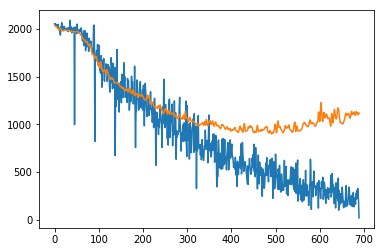

In [60]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.plot(range(len(loss1)),loss1)
plt.plot(range(len(loss2)),loss2)

In [25]:
model = NeuralNet().to(device)
loss_list = []
# if we're only testing, we don't want to train for any epochs, and we want to load a model
if not is_train:
    num_epochs = 0
    model.load_state_dict(torch.load('model.ckpt'))

# Loss and optimizer
criterion = torch.nn.CrossEntropyLoss(reduce=False, size_average=False) #TODO: define your loss here. hint: should just require calling a built-in pytorch layer.
# NOTE: you can use a different optimizer besides Adam, like RMSProp or SGD, if you'd like
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
# Loop over epochs
print('Beginning training..')
total_step = len(train_loader)
loss_list = []
for epoch in range(num_epochs):
    # Training
    print('epoch {}'.format(epoch))
    for i, (local_batch,local_labels) in enumerate(train_loader):
        # Transfer to GPU
        local_ims, local_labels = local_batch.to(device), local_labels.to(device)
        
        # Forward pass
        outputs = model.forward(local_ims)
        loss = criterion(outputs, local_labels).sum()
        # TODO: maintain a list of your losses as a function of number of steps
        #       because we ask you to plot this information
        # NOTE: if you use Google Colab's tensorboard-like feature to visualize
        #       the loss, you do not need to plot it here. just take a screenshot
        #       of the loss curve and include it in your write-up.
        #print(loss.item())
        loss_list.append(loss.item())
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 4 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, total_step, loss.item()))

end = time.time()
print('Time: {}'.format(end - start))

# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
print('Beginning Testing..')
with torch.no_grad():
    correct = 0
    total = 0
    predicted_list = []
    groundtruth_list = []
    for (local_batch,local_labels) in val_loader:
        # Transfer to GPU
        local_ims, local_labels = local_batch.to(device), local_labels.to(device)

        outputs = model.forward(local_ims)
        _, predicted = torch.max(outputs.data, 1)
        total += local_labels.size(0)
        predicted_list.extend(predicted)
        groundtruth_list.extend(local_labels)
        correct += (predicted == local_labels).sum().item()

    print('Accuracy of the network on the {} test images: {} %'
          .format(total, 100 * correct / total))

# Look at some things about the model results..
# convert the predicted_list and groundtruth_list Tensors to lists
pl = [p.cpu().numpy().tolist() for p in predicted_list]
gt = [p.cpu().numpy().tolist() for p in groundtruth_list]

# TODO: use pl and gt to produce your confusion matrices
from sklearn.metrics import confusion_matrix
confusion_m = confusion_matrix(gt, pl)

# view the per-movement accuracy
label_map = ['reach','squat','inline','lunge','hamstrings','stretch','deadbug','pushup']
for id in range(len(label_map)):
    print('{}: {}'.format(label_map[id],sum([p and g for (p,g) in zip(np.array(pl)==np.array(gt),np.array(gt)==id)])/(sum(np.array(gt)==id)+0.)))

Beginning training..
epoch 0
Epoch [1/25], Step [4/46], Loss: 132.4995
Epoch [1/25], Step [8/46], Loss: 134.0070
Epoch [1/25], Step [12/46], Loss: 130.6303
Epoch [1/25], Step [16/46], Loss: 126.4795
Epoch [1/25], Step [20/46], Loss: 127.5393
Epoch [1/25], Step [24/46], Loss: 130.1460
Epoch [1/25], Step [28/46], Loss: 123.8864
Epoch [1/25], Step [32/46], Loss: 127.3067
Epoch [1/25], Step [36/46], Loss: 128.8626
Epoch [1/25], Step [40/46], Loss: 127.3737
Epoch [1/25], Step [44/46], Loss: 123.7723
epoch 1
Epoch [2/25], Step [4/46], Loss: 114.7587
Epoch [2/25], Step [8/46], Loss: 109.1737
Epoch [2/25], Step [12/46], Loss: 118.1739
Epoch [2/25], Step [16/46], Loss: 119.3957
Epoch [2/25], Step [20/46], Loss: 115.7085
Epoch [2/25], Step [24/46], Loss: 117.9288
Epoch [2/25], Step [28/46], Loss: 119.3055
Epoch [2/25], Step [32/46], Loss: 98.0466
Epoch [2/25], Step [36/46], Loss: 117.0755
Epoch [2/25], Step [40/46], Loss: 106.6386
Epoch [2/25], Step [44/46], Loss: 101.9718
epoch 2
Epoch [3/25], 

Epoch [18/25], Step [16/46], Loss: 5.7774
Epoch [18/25], Step [20/46], Loss: 0.7774
Epoch [18/25], Step [24/46], Loss: 3.8626
Epoch [18/25], Step [28/46], Loss: 1.3217
Epoch [18/25], Step [32/46], Loss: 5.4888
Epoch [18/25], Step [36/46], Loss: 7.5961
Epoch [18/25], Step [40/46], Loss: 5.5560
Epoch [18/25], Step [44/46], Loss: 3.2472
epoch 18
Epoch [19/25], Step [4/46], Loss: 6.4233
Epoch [19/25], Step [8/46], Loss: 8.4379
Epoch [19/25], Step [12/46], Loss: 3.5740
Epoch [19/25], Step [16/46], Loss: 1.1230
Epoch [19/25], Step [20/46], Loss: 6.8138
Epoch [19/25], Step [24/46], Loss: 12.1419
Epoch [19/25], Step [28/46], Loss: 7.6875
Epoch [19/25], Step [32/46], Loss: 2.0277
Epoch [19/25], Step [36/46], Loss: 3.6486
Epoch [19/25], Step [40/46], Loss: 4.2888
Epoch [19/25], Step [44/46], Loss: 2.5950
epoch 19
Epoch [20/25], Step [4/46], Loss: 1.1897
Epoch [20/25], Step [8/46], Loss: 0.4890
Epoch [20/25], Step [12/46], Loss: 5.2773
Epoch [20/25], Step [16/46], Loss: 5.9116
Epoch [20/25], Step

In [9]:
confusion_m

array([[ 61,   1,  11,   1,   0,   0,   0,   1],
       [  1,  55,   7,   4,   4,   2,   1,   1],
       [ 12,   5, 118,   3,   9,   2,   0,   1],
       [  6,   6,  10, 112,   2,   6,   1,   7],
       [  5,   1,   6,   4, 107,  11,  10,   6],
       [  6,   2,   3,   3,   8, 116,   5,   7],
       [  0,   2,   4,   7,  12,  12, 107,   6],
       [  2,   1,   3,   2,   1,   5,   4,  57]])

In [91]:
# flag for whether you're training or not
is_train = True
is_key_frame = False # TODO: set this to false to train on the video frames, instead of the key frames
model_to_load = 'model.ckpt' # This is the model to load during testing, if you want to eval a previously-trained model.

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
#cudnn.benchmark = True

# Parameters for data loader
params = {'batch_size': 64,  # TODO: fill in the batch size. often, these are things like 32,64,128,or 256
          'shuffle': True,
          'num_workers': 30 
          }

In [92]:
# TODO: Hyper-parameters
num_epochs = 25
learning_rate = 0.0001
# NOTE: depending on your optimizer, you may want to tune other hyperparameters as well

# Datasets
# TODO: put the path to your train, test, validation txt files
if is_key_frame:
    label_file_train =  './data/keyframe_data_train.txt'
    label_file_val  =  './data/keyframe_data_val.txt'
    # NOTE: the kaggle competition test data is only for the video frames, not the key frames
    # this is why we don't have an equivalent label_file_test with keyframes
else:
    label_file_train = './data/videoframe_data_train.txt'
    label_file_val = './data/videoframe_data_val.txt'
    label_file_test = './data/videoframe_data_test.txt'

# TODO: you should normalize based on the average image in the training set. This shows 
# an example of doing normalization
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]
# TODO: if you want to pad or resize your images, you can put the parameters for that below.

# Generators
# NOTE: if you don't want to pad or resize your images, you should delete the Pad and Resize
# transforms from all three _dataset definitions.
train_dataset = Mds189(label_file_train,loader=default_loader,transform=transforms.Compose([
                                               #transforms.Pad(1),    # TODO: if you want to pad your images
                                               #transforms.Resize(256), # TODO: if you want to resize your images
                                               transforms.ToTensor(),
                                               transforms.Normalize(mean, std)
                                           ]))
train_loader = data.DataLoader(train_dataset, **params)

val_dataset = Mds189(label_file_val,loader=default_loader,transform=transforms.Compose([
                                               #transforms.Pad(1),
                                               #transforms.Resize(256),
                                               transforms.ToTensor(),
                                               transforms.Normalize(mean, std)
                                           ]))
val_loader = data.DataLoader(val_dataset, **params)

if not is_key_frame:
    test_dataset = Mds189(label_file_test,loader=default_loader,transform=transforms.Compose([
                                                   #transforms.Pad(1),
                                                   #transforms.Resize(256),
                                                   transforms.ToTensor(),
                                                   transforms.Normalize(mean, std)
                                               ]))
    test_loader = data.DataLoader(test_dataset, **params)



In [93]:
model = NeuralNet().to(device)
loss_list2 = []
# if we're only testing, we don't want to train for any epochs, and we want to load a model
if not is_train:
    num_epochs = 0
    model.load_state_dict(torch.load('model.ckpt'))

# Loss and optimizer
criterion = torch.nn.CrossEntropyLoss(reduce=False, size_average=False) #TODO: define your loss here. hint: should just require calling a built-in pytorch layer.
# NOTE: you can use a different optimizer besides Adam, like RMSProp or SGD, if you'd like
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
# Loop over epochs
print('Beginning training..')
total_step = len(train_loader)
loss_list2 = []
for epoch in range(num_epochs):
    # Training
    print('epoch {}'.format(epoch))
    for i, (local_batch,local_labels) in enumerate(train_loader):
        # Transfer to GPU
        local_ims, local_labels = local_batch.to(device), local_labels.to(device)
        
        # Forward pass
        outputs = model.forward(local_ims)
        loss = criterion(outputs, local_labels).sum()
        # TODO: maintain a list of your losses as a function of number of steps
        #       because we ask you to plot this information
        # NOTE: if you use Google Colab's tensorboard-like feature to visualize
        #       the loss, you do not need to plot it here. just take a screenshot
        #       of the loss curve and include it in your write-up.
        #print(loss.item())
        loss_list2.append(loss.item())
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 4 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, total_step, loss.item()))

end = time.time()
print('Time: {}'.format(end - start))

# Test the model
# In test phase, we don't need to compute gradients (for memory efficiency)
print('Beginning Testing..')
with torch.no_grad():
    correct = 0
    total = 0
    predicted_list = []
    groundtruth_list = []
    for (local_batch,local_labels) in val_loader:
        # Transfer to GPU
        local_ims, local_labels = local_batch.to(device), local_labels.to(device)

        outputs = model.forward(local_ims)
        _, predicted = torch.max(outputs.data, 1)
        total += local_labels.size(0)
        predicted_list.extend(predicted)
        groundtruth_list.extend(local_labels)
        correct += (predicted == local_labels).sum().item()

    print('Accuracy of the network on the {} test images: {} %'
          .format(total, 100 * correct / total))

# Look at some things about the model results..
# convert the predicted_list and groundtruth_list Tensors to lists
pl = [p.cpu().numpy().tolist() for p in predicted_list]
gt = [p.cpu().numpy().tolist() for p in groundtruth_list]

# TODO: use pl and gt to produce your confusion matrices
from sklearn.metrics import confusion_matrix
confusion_m = confusion_matrix(gt, pl)

# view the per-movement accuracy
label_map = ['reach','squat','inline','lunge','hamstrings','stretch','deadbug','pushup']
for id in range(len(label_map)):
    print('{}: {}'.format(label_map[id],sum([p and g for (p,g) in zip(np.array(pl)==np.array(gt),np.array(gt)==id)])/(sum(np.array(gt)==id)+0.)))

Beginning training..
epoch 0


/home/wenbo2/anaconda3/envs/fastai/lib/python3.6/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


Epoch [1/25], Step [4/590], Loss: 132.7683
Epoch [1/25], Step [8/590], Loss: 131.1727
Epoch [1/25], Step [12/590], Loss: 131.6251
Epoch [1/25], Step [16/590], Loss: 130.6518
Epoch [1/25], Step [20/590], Loss: 132.3721
Epoch [1/25], Step [24/590], Loss: 131.3639
Epoch [1/25], Step [28/590], Loss: 130.8371
Epoch [1/25], Step [32/590], Loss: 131.3049
Epoch [1/25], Step [36/590], Loss: 128.1117
Epoch [1/25], Step [40/590], Loss: 131.8998
Epoch [1/25], Step [44/590], Loss: 128.5308
Epoch [1/25], Step [48/590], Loss: 128.3570
Epoch [1/25], Step [52/590], Loss: 132.8541
Epoch [1/25], Step [56/590], Loss: 128.6715
Epoch [1/25], Step [60/590], Loss: 124.8024
Epoch [1/25], Step [64/590], Loss: 130.4782
Epoch [1/25], Step [68/590], Loss: 129.8755
Epoch [1/25], Step [72/590], Loss: 129.0356
Epoch [1/25], Step [76/590], Loss: 128.3780
Epoch [1/25], Step [80/590], Loss: 126.6509
Epoch [1/25], Step [84/590], Loss: 126.5151
Epoch [1/25], Step [88/590], Loss: 122.3848
Epoch [1/25], Step [92/590], Loss:

Epoch [2/25], Step [164/590], Loss: 35.7189
Epoch [2/25], Step [168/590], Loss: 31.9827
Epoch [2/25], Step [172/590], Loss: 41.2650
Epoch [2/25], Step [176/590], Loss: 36.1515
Epoch [2/25], Step [180/590], Loss: 24.9524
Epoch [2/25], Step [184/590], Loss: 35.5971
Epoch [2/25], Step [188/590], Loss: 40.6738
Epoch [2/25], Step [192/590], Loss: 31.4475
Epoch [2/25], Step [196/590], Loss: 27.9428
Epoch [2/25], Step [200/590], Loss: 30.9912
Epoch [2/25], Step [204/590], Loss: 33.6154
Epoch [2/25], Step [208/590], Loss: 38.5541
Epoch [2/25], Step [212/590], Loss: 41.9552
Epoch [2/25], Step [216/590], Loss: 40.0477
Epoch [2/25], Step [220/590], Loss: 30.4736
Epoch [2/25], Step [224/590], Loss: 29.1196
Epoch [2/25], Step [228/590], Loss: 26.9132
Epoch [2/25], Step [232/590], Loss: 24.7780
Epoch [2/25], Step [236/590], Loss: 32.8177
Epoch [2/25], Step [240/590], Loss: 33.9107
Epoch [2/25], Step [244/590], Loss: 34.6374
Epoch [2/25], Step [248/590], Loss: 28.0133
Epoch [2/25], Step [252/590], Lo

Epoch [3/25], Step [324/590], Loss: 13.7369
Epoch [3/25], Step [328/590], Loss: 19.6116
Epoch [3/25], Step [332/590], Loss: 12.8418
Epoch [3/25], Step [336/590], Loss: 14.9764
Epoch [3/25], Step [340/590], Loss: 10.6412
Epoch [3/25], Step [344/590], Loss: 12.7865
Epoch [3/25], Step [348/590], Loss: 14.5134
Epoch [3/25], Step [352/590], Loss: 10.1731
Epoch [3/25], Step [356/590], Loss: 14.3945
Epoch [3/25], Step [360/590], Loss: 12.4252
Epoch [3/25], Step [364/590], Loss: 16.6590
Epoch [3/25], Step [368/590], Loss: 11.3807
Epoch [3/25], Step [372/590], Loss: 16.2051
Epoch [3/25], Step [376/590], Loss: 22.0892
Epoch [3/25], Step [380/590], Loss: 16.1594
Epoch [3/25], Step [384/590], Loss: 17.6668
Epoch [3/25], Step [388/590], Loss: 14.3764
Epoch [3/25], Step [392/590], Loss: 6.1202
Epoch [3/25], Step [396/590], Loss: 12.7490
Epoch [3/25], Step [400/590], Loss: 12.4245
Epoch [3/25], Step [404/590], Loss: 20.3768
Epoch [3/25], Step [408/590], Loss: 15.1903
Epoch [3/25], Step [412/590], Los

Epoch [4/25], Step [492/590], Loss: 13.5626
Epoch [4/25], Step [496/590], Loss: 10.8120
Epoch [4/25], Step [500/590], Loss: 17.8870
Epoch [4/25], Step [504/590], Loss: 5.4569
Epoch [4/25], Step [508/590], Loss: 6.4002
Epoch [4/25], Step [512/590], Loss: 5.0246
Epoch [4/25], Step [516/590], Loss: 11.0510
Epoch [4/25], Step [520/590], Loss: 8.2906
Epoch [4/25], Step [524/590], Loss: 5.5962
Epoch [4/25], Step [528/590], Loss: 12.1214
Epoch [4/25], Step [532/590], Loss: 5.4143
Epoch [4/25], Step [536/590], Loss: 6.6691
Epoch [4/25], Step [540/590], Loss: 11.7599
Epoch [4/25], Step [544/590], Loss: 4.2995
Epoch [4/25], Step [548/590], Loss: 5.1377
Epoch [4/25], Step [552/590], Loss: 6.7846
Epoch [4/25], Step [556/590], Loss: 11.3952
Epoch [4/25], Step [560/590], Loss: 10.6068
Epoch [4/25], Step [564/590], Loss: 15.8064
Epoch [4/25], Step [568/590], Loss: 8.7861
Epoch [4/25], Step [572/590], Loss: 12.9969
Epoch [4/25], Step [576/590], Loss: 5.9465
Epoch [4/25], Step [580/590], Loss: 11.2010


Epoch [6/25], Step [80/590], Loss: 4.1793
Epoch [6/25], Step [84/590], Loss: 5.1372
Epoch [6/25], Step [88/590], Loss: 1.9301
Epoch [6/25], Step [92/590], Loss: 2.0594
Epoch [6/25], Step [96/590], Loss: 7.8133
Epoch [6/25], Step [100/590], Loss: 2.9460
Epoch [6/25], Step [104/590], Loss: 0.3954
Epoch [6/25], Step [108/590], Loss: 7.4262
Epoch [6/25], Step [112/590], Loss: 3.1251
Epoch [6/25], Step [116/590], Loss: 0.9147
Epoch [6/25], Step [120/590], Loss: 7.8174
Epoch [6/25], Step [124/590], Loss: 3.9351
Epoch [6/25], Step [128/590], Loss: 2.3984
Epoch [6/25], Step [132/590], Loss: 4.1068
Epoch [6/25], Step [136/590], Loss: 2.4294
Epoch [6/25], Step [140/590], Loss: 1.2221
Epoch [6/25], Step [144/590], Loss: 1.8034
Epoch [6/25], Step [148/590], Loss: 1.0052
Epoch [6/25], Step [152/590], Loss: 5.3887
Epoch [6/25], Step [156/590], Loss: 3.2008
Epoch [6/25], Step [160/590], Loss: 2.0818
Epoch [6/25], Step [164/590], Loss: 6.9533
Epoch [6/25], Step [168/590], Loss: 7.8026
Epoch [6/25], St

Epoch [7/25], Step [256/590], Loss: 5.8094
Epoch [7/25], Step [260/590], Loss: 0.9281
Epoch [7/25], Step [264/590], Loss: 1.2714
Epoch [7/25], Step [268/590], Loss: 1.5316
Epoch [7/25], Step [272/590], Loss: 5.5560
Epoch [7/25], Step [276/590], Loss: 1.3080
Epoch [7/25], Step [280/590], Loss: 5.0390
Epoch [7/25], Step [284/590], Loss: 2.1937
Epoch [7/25], Step [288/590], Loss: 1.1670
Epoch [7/25], Step [292/590], Loss: 0.6418
Epoch [7/25], Step [296/590], Loss: 1.4169
Epoch [7/25], Step [300/590], Loss: 1.8254
Epoch [7/25], Step [304/590], Loss: 3.6098
Epoch [7/25], Step [308/590], Loss: 0.5035
Epoch [7/25], Step [312/590], Loss: 6.0277
Epoch [7/25], Step [316/590], Loss: 0.5947
Epoch [7/25], Step [320/590], Loss: 1.1794
Epoch [7/25], Step [324/590], Loss: 2.6229
Epoch [7/25], Step [328/590], Loss: 2.3344
Epoch [7/25], Step [332/590], Loss: 1.9175
Epoch [7/25], Step [336/590], Loss: 3.9507
Epoch [7/25], Step [340/590], Loss: 0.2594
Epoch [7/25], Step [344/590], Loss: 1.9381
Epoch [7/25

Epoch [8/25], Step [432/590], Loss: 9.5260
Epoch [8/25], Step [436/590], Loss: 1.1436
Epoch [8/25], Step [440/590], Loss: 2.1824
Epoch [8/25], Step [444/590], Loss: 4.7788
Epoch [8/25], Step [448/590], Loss: 0.6571
Epoch [8/25], Step [452/590], Loss: 9.8710
Epoch [8/25], Step [456/590], Loss: 0.4511
Epoch [8/25], Step [460/590], Loss: 2.3014
Epoch [8/25], Step [464/590], Loss: 0.6874
Epoch [8/25], Step [468/590], Loss: 0.2863
Epoch [8/25], Step [472/590], Loss: 1.6098
Epoch [8/25], Step [476/590], Loss: 0.4196
Epoch [8/25], Step [480/590], Loss: 0.3266
Epoch [8/25], Step [484/590], Loss: 1.3032
Epoch [8/25], Step [488/590], Loss: 0.6983
Epoch [8/25], Step [492/590], Loss: 1.6298
Epoch [8/25], Step [496/590], Loss: 3.4331
Epoch [8/25], Step [500/590], Loss: 1.3591
Epoch [8/25], Step [504/590], Loss: 6.0170
Epoch [8/25], Step [508/590], Loss: 0.4681
Epoch [8/25], Step [512/590], Loss: 0.5299
Epoch [8/25], Step [516/590], Loss: 0.8514
Epoch [8/25], Step [520/590], Loss: 1.2944
Epoch [8/25

Epoch [10/25], Step [20/590], Loss: 0.1881
Epoch [10/25], Step [24/590], Loss: 1.1677
Epoch [10/25], Step [28/590], Loss: 2.0676
Epoch [10/25], Step [32/590], Loss: 1.0161
Epoch [10/25], Step [36/590], Loss: 0.8176
Epoch [10/25], Step [40/590], Loss: 1.8567
Epoch [10/25], Step [44/590], Loss: 0.3887
Epoch [10/25], Step [48/590], Loss: 5.9305
Epoch [10/25], Step [52/590], Loss: 1.6362
Epoch [10/25], Step [56/590], Loss: 0.6132
Epoch [10/25], Step [60/590], Loss: 0.1311
Epoch [10/25], Step [64/590], Loss: 0.6295
Epoch [10/25], Step [68/590], Loss: 0.0458
Epoch [10/25], Step [72/590], Loss: 0.0672
Epoch [10/25], Step [76/590], Loss: 0.5017
Epoch [10/25], Step [80/590], Loss: 0.2616
Epoch [10/25], Step [84/590], Loss: 0.2255
Epoch [10/25], Step [88/590], Loss: 0.5839
Epoch [10/25], Step [92/590], Loss: 4.8913
Epoch [10/25], Step [96/590], Loss: 0.2791
Epoch [10/25], Step [100/590], Loss: 0.0399
Epoch [10/25], Step [104/590], Loss: 0.1787
Epoch [10/25], Step [108/590], Loss: 3.7003
Epoch [1

Epoch [11/25], Step [180/590], Loss: 0.8072
Epoch [11/25], Step [184/590], Loss: 2.5857
Epoch [11/25], Step [188/590], Loss: 1.3169
Epoch [11/25], Step [192/590], Loss: 3.1881
Epoch [11/25], Step [196/590], Loss: 4.2226
Epoch [11/25], Step [200/590], Loss: 0.5133
Epoch [11/25], Step [204/590], Loss: 0.7639
Epoch [11/25], Step [208/590], Loss: 0.2910
Epoch [11/25], Step [212/590], Loss: 0.1720
Epoch [11/25], Step [216/590], Loss: 0.3548
Epoch [11/25], Step [220/590], Loss: 3.2268
Epoch [11/25], Step [224/590], Loss: 1.2122
Epoch [11/25], Step [228/590], Loss: 0.2789
Epoch [11/25], Step [232/590], Loss: 0.1160
Epoch [11/25], Step [236/590], Loss: 0.1015
Epoch [11/25], Step [240/590], Loss: 0.4439
Epoch [11/25], Step [244/590], Loss: 0.3290
Epoch [11/25], Step [248/590], Loss: 0.1383
Epoch [11/25], Step [252/590], Loss: 0.8691
Epoch [11/25], Step [256/590], Loss: 0.2912
Epoch [11/25], Step [260/590], Loss: 0.4074
Epoch [11/25], Step [264/590], Loss: 4.1079
Epoch [11/25], Step [268/590], L

Epoch [12/25], Step [340/590], Loss: 3.5237
Epoch [12/25], Step [344/590], Loss: 0.4598
Epoch [12/25], Step [348/590], Loss: 3.5345
Epoch [12/25], Step [352/590], Loss: 0.2553
Epoch [12/25], Step [356/590], Loss: 2.6334
Epoch [12/25], Step [360/590], Loss: 0.5525
Epoch [12/25], Step [364/590], Loss: 0.7417
Epoch [12/25], Step [368/590], Loss: 0.0990
Epoch [12/25], Step [372/590], Loss: 0.7026
Epoch [12/25], Step [376/590], Loss: 1.9076
Epoch [12/25], Step [380/590], Loss: 0.2661
Epoch [12/25], Step [384/590], Loss: 1.1747
Epoch [12/25], Step [388/590], Loss: 0.9790
Epoch [12/25], Step [392/590], Loss: 1.5614
Epoch [12/25], Step [396/590], Loss: 6.6142
Epoch [12/25], Step [400/590], Loss: 0.2587
Epoch [12/25], Step [404/590], Loss: 1.3785
Epoch [12/25], Step [408/590], Loss: 0.2373
Epoch [12/25], Step [412/590], Loss: 0.4805
Epoch [12/25], Step [416/590], Loss: 0.4508
Epoch [12/25], Step [420/590], Loss: 0.1945
Epoch [12/25], Step [424/590], Loss: 0.6499
Epoch [12/25], Step [428/590], L

Epoch [13/25], Step [500/590], Loss: 2.0329
Epoch [13/25], Step [504/590], Loss: 0.3468
Epoch [13/25], Step [508/590], Loss: 0.0499
Epoch [13/25], Step [512/590], Loss: 0.2712
Epoch [13/25], Step [516/590], Loss: 0.3096
Epoch [13/25], Step [520/590], Loss: 0.6004
Epoch [13/25], Step [524/590], Loss: 0.9961
Epoch [13/25], Step [528/590], Loss: 0.1460
Epoch [13/25], Step [532/590], Loss: 0.0714
Epoch [13/25], Step [536/590], Loss: 0.3787
Epoch [13/25], Step [540/590], Loss: 1.6951
Epoch [13/25], Step [544/590], Loss: 1.3761
Epoch [13/25], Step [548/590], Loss: 1.0746
Epoch [13/25], Step [552/590], Loss: 0.5512
Epoch [13/25], Step [556/590], Loss: 3.9748
Epoch [13/25], Step [560/590], Loss: 1.0831
Epoch [13/25], Step [564/590], Loss: 1.0797
Epoch [13/25], Step [568/590], Loss: 0.3392
Epoch [13/25], Step [572/590], Loss: 3.4923
Epoch [13/25], Step [576/590], Loss: 0.2681
Epoch [13/25], Step [580/590], Loss: 1.0210
Epoch [13/25], Step [584/590], Loss: 1.1901
Epoch [13/25], Step [588/590], L

Epoch [15/25], Step [72/590], Loss: 1.8240
Epoch [15/25], Step [76/590], Loss: 1.0467
Epoch [15/25], Step [80/590], Loss: 3.9232
Epoch [15/25], Step [84/590], Loss: 0.3681
Epoch [15/25], Step [88/590], Loss: 2.6950
Epoch [15/25], Step [92/590], Loss: 0.5255
Epoch [15/25], Step [96/590], Loss: 1.9928
Epoch [15/25], Step [100/590], Loss: 0.9675
Epoch [15/25], Step [104/590], Loss: 1.0502
Epoch [15/25], Step [108/590], Loss: 0.2962
Epoch [15/25], Step [112/590], Loss: 0.3677
Epoch [15/25], Step [116/590], Loss: 0.2923
Epoch [15/25], Step [120/590], Loss: 2.9975
Epoch [15/25], Step [124/590], Loss: 1.8771
Epoch [15/25], Step [128/590], Loss: 0.7857
Epoch [15/25], Step [132/590], Loss: 4.4750
Epoch [15/25], Step [136/590], Loss: 0.7053
Epoch [15/25], Step [140/590], Loss: 0.0696
Epoch [15/25], Step [144/590], Loss: 0.2419
Epoch [15/25], Step [148/590], Loss: 1.3479
Epoch [15/25], Step [152/590], Loss: 1.3161
Epoch [15/25], Step [156/590], Loss: 0.6799
Epoch [15/25], Step [160/590], Loss: 0.

Epoch [16/25], Step [232/590], Loss: 0.0827
Epoch [16/25], Step [236/590], Loss: 0.3360
Epoch [16/25], Step [240/590], Loss: 0.2410
Epoch [16/25], Step [244/590], Loss: 0.2185
Epoch [16/25], Step [248/590], Loss: 1.0330
Epoch [16/25], Step [252/590], Loss: 0.1288
Epoch [16/25], Step [256/590], Loss: 0.9099
Epoch [16/25], Step [260/590], Loss: 1.9354
Epoch [16/25], Step [264/590], Loss: 0.3325
Epoch [16/25], Step [268/590], Loss: 0.6583
Epoch [16/25], Step [272/590], Loss: 3.0841
Epoch [16/25], Step [276/590], Loss: 0.5646
Epoch [16/25], Step [280/590], Loss: 0.2929
Epoch [16/25], Step [284/590], Loss: 0.2499
Epoch [16/25], Step [288/590], Loss: 0.4909
Epoch [16/25], Step [292/590], Loss: 0.0235
Epoch [16/25], Step [296/590], Loss: 0.3127
Epoch [16/25], Step [300/590], Loss: 0.9730
Epoch [16/25], Step [304/590], Loss: 0.2682
Epoch [16/25], Step [308/590], Loss: 5.6054
Epoch [16/25], Step [312/590], Loss: 0.1381
Epoch [16/25], Step [316/590], Loss: 0.0185
Epoch [16/25], Step [320/590], L

Epoch [17/25], Step [392/590], Loss: 0.0745
Epoch [17/25], Step [396/590], Loss: 1.1365
Epoch [17/25], Step [400/590], Loss: 0.1454
Epoch [17/25], Step [404/590], Loss: 0.6636
Epoch [17/25], Step [408/590], Loss: 0.2371
Epoch [17/25], Step [412/590], Loss: 0.6047
Epoch [17/25], Step [416/590], Loss: 0.0481
Epoch [17/25], Step [420/590], Loss: 0.4571
Epoch [17/25], Step [424/590], Loss: 2.3697
Epoch [17/25], Step [428/590], Loss: 0.5909
Epoch [17/25], Step [432/590], Loss: 0.8248
Epoch [17/25], Step [436/590], Loss: 1.1454
Epoch [17/25], Step [440/590], Loss: 0.0702
Epoch [17/25], Step [444/590], Loss: 0.1827
Epoch [17/25], Step [448/590], Loss: 0.0921
Epoch [17/25], Step [452/590], Loss: 1.4077
Epoch [17/25], Step [456/590], Loss: 0.0723
Epoch [17/25], Step [460/590], Loss: 0.1096
Epoch [17/25], Step [464/590], Loss: 0.1381
Epoch [17/25], Step [468/590], Loss: 1.8255
Epoch [17/25], Step [472/590], Loss: 0.4410
Epoch [17/25], Step [476/590], Loss: 0.0787
Epoch [17/25], Step [480/590], L

Epoch [18/25], Step [552/590], Loss: 4.2612
Epoch [18/25], Step [556/590], Loss: 2.2364
Epoch [18/25], Step [560/590], Loss: 0.2490
Epoch [18/25], Step [564/590], Loss: 0.7383
Epoch [18/25], Step [568/590], Loss: 1.8823
Epoch [18/25], Step [572/590], Loss: 0.2622
Epoch [18/25], Step [576/590], Loss: 1.5452
Epoch [18/25], Step [580/590], Loss: 0.5333
Epoch [18/25], Step [584/590], Loss: 2.0321
Epoch [18/25], Step [588/590], Loss: 1.7739
epoch 18
Epoch [19/25], Step [4/590], Loss: 0.2696
Epoch [19/25], Step [8/590], Loss: 1.5977
Epoch [19/25], Step [12/590], Loss: 0.5346
Epoch [19/25], Step [16/590], Loss: 0.8895
Epoch [19/25], Step [20/590], Loss: 0.1129
Epoch [19/25], Step [24/590], Loss: 0.3937
Epoch [19/25], Step [28/590], Loss: 0.1275
Epoch [19/25], Step [32/590], Loss: 0.0850
Epoch [19/25], Step [36/590], Loss: 0.4654
Epoch [19/25], Step [40/590], Loss: 1.0542
Epoch [19/25], Step [44/590], Loss: 0.2735
Epoch [19/25], Step [48/590], Loss: 0.3036
Epoch [19/25], Step [52/590], Loss: 0

Epoch [20/25], Step [124/590], Loss: 0.2671
Epoch [20/25], Step [128/590], Loss: 0.0291
Epoch [20/25], Step [132/590], Loss: 0.0084
Epoch [20/25], Step [136/590], Loss: 0.0420
Epoch [20/25], Step [140/590], Loss: 0.0796
Epoch [20/25], Step [144/590], Loss: 0.3895
Epoch [20/25], Step [148/590], Loss: 0.0067
Epoch [20/25], Step [152/590], Loss: 0.1865
Epoch [20/25], Step [156/590], Loss: 0.3470
Epoch [20/25], Step [160/590], Loss: 0.1476
Epoch [20/25], Step [164/590], Loss: 0.0862
Epoch [20/25], Step [168/590], Loss: 0.0983
Epoch [20/25], Step [172/590], Loss: 0.5496
Epoch [20/25], Step [176/590], Loss: 0.0318
Epoch [20/25], Step [180/590], Loss: 0.9056
Epoch [20/25], Step [184/590], Loss: 0.3634
Epoch [20/25], Step [188/590], Loss: 0.6637
Epoch [20/25], Step [192/590], Loss: 0.7730
Epoch [20/25], Step [196/590], Loss: 0.0162
Epoch [20/25], Step [200/590], Loss: 9.6136
Epoch [20/25], Step [204/590], Loss: 0.5040
Epoch [20/25], Step [208/590], Loss: 4.7080
Epoch [20/25], Step [212/590], L

Epoch [21/25], Step [284/590], Loss: 0.2102
Epoch [21/25], Step [288/590], Loss: 0.0320
Epoch [21/25], Step [292/590], Loss: 1.8069
Epoch [21/25], Step [296/590], Loss: 2.7170
Epoch [21/25], Step [300/590], Loss: 0.5528
Epoch [21/25], Step [304/590], Loss: 0.9082
Epoch [21/25], Step [308/590], Loss: 0.4817
Epoch [21/25], Step [312/590], Loss: 0.4064
Epoch [21/25], Step [316/590], Loss: 0.2697
Epoch [21/25], Step [320/590], Loss: 3.0547
Epoch [21/25], Step [324/590], Loss: 0.5742
Epoch [21/25], Step [328/590], Loss: 0.0362
Epoch [21/25], Step [332/590], Loss: 6.2837
Epoch [21/25], Step [336/590], Loss: 0.2886
Epoch [21/25], Step [340/590], Loss: 0.5744
Epoch [21/25], Step [344/590], Loss: 0.1718
Epoch [21/25], Step [348/590], Loss: 0.8326
Epoch [21/25], Step [352/590], Loss: 0.0103
Epoch [21/25], Step [356/590], Loss: 0.0915
Epoch [21/25], Step [360/590], Loss: 0.5361
Epoch [21/25], Step [364/590], Loss: 0.0118
Epoch [21/25], Step [368/590], Loss: 0.2614
Epoch [21/25], Step [372/590], L

Epoch [22/25], Step [444/590], Loss: 0.5363
Epoch [22/25], Step [448/590], Loss: 0.0838
Epoch [22/25], Step [452/590], Loss: 0.6823
Epoch [22/25], Step [456/590], Loss: 1.1887
Epoch [22/25], Step [460/590], Loss: 0.4684
Epoch [22/25], Step [464/590], Loss: 0.5826
Epoch [22/25], Step [468/590], Loss: 0.5306
Epoch [22/25], Step [472/590], Loss: 0.0606
Epoch [22/25], Step [476/590], Loss: 0.5496
Epoch [22/25], Step [480/590], Loss: 1.6583
Epoch [22/25], Step [484/590], Loss: 0.1116
Epoch [22/25], Step [488/590], Loss: 0.6683
Epoch [22/25], Step [492/590], Loss: 0.0174
Epoch [22/25], Step [496/590], Loss: 0.2455
Epoch [22/25], Step [500/590], Loss: 0.3104
Epoch [22/25], Step [504/590], Loss: 0.2215
Epoch [22/25], Step [508/590], Loss: 0.7880
Epoch [22/25], Step [512/590], Loss: 0.2769
Epoch [22/25], Step [516/590], Loss: 0.5248
Epoch [22/25], Step [520/590], Loss: 0.0272
Epoch [22/25], Step [524/590], Loss: 0.0134
Epoch [22/25], Step [528/590], Loss: 0.9590
Epoch [22/25], Step [532/590], L

Epoch [24/25], Step [16/590], Loss: 3.5012
Epoch [24/25], Step [20/590], Loss: 2.1276
Epoch [24/25], Step [24/590], Loss: 0.0273
Epoch [24/25], Step [28/590], Loss: 0.0182
Epoch [24/25], Step [32/590], Loss: 0.0944
Epoch [24/25], Step [36/590], Loss: 0.0420
Epoch [24/25], Step [40/590], Loss: 0.0213
Epoch [24/25], Step [44/590], Loss: 0.1191
Epoch [24/25], Step [48/590], Loss: 0.5769
Epoch [24/25], Step [52/590], Loss: 0.3950
Epoch [24/25], Step [56/590], Loss: 1.3823
Epoch [24/25], Step [60/590], Loss: 0.1769
Epoch [24/25], Step [64/590], Loss: 0.0825
Epoch [24/25], Step [68/590], Loss: 0.0148
Epoch [24/25], Step [72/590], Loss: 0.1279
Epoch [24/25], Step [76/590], Loss: 0.0129
Epoch [24/25], Step [80/590], Loss: 9.7210
Epoch [24/25], Step [84/590], Loss: 0.0772
Epoch [24/25], Step [88/590], Loss: 0.0856
Epoch [24/25], Step [92/590], Loss: 0.0133
Epoch [24/25], Step [96/590], Loss: 0.0632
Epoch [24/25], Step [100/590], Loss: 0.1796
Epoch [24/25], Step [104/590], Loss: 0.0824
Epoch [24

Epoch [25/25], Step [180/590], Loss: 0.4279
Epoch [25/25], Step [184/590], Loss: 1.9606
Epoch [25/25], Step [188/590], Loss: 0.0340
Epoch [25/25], Step [192/590], Loss: 0.7612
Epoch [25/25], Step [196/590], Loss: 5.7060
Epoch [25/25], Step [200/590], Loss: 1.1746
Epoch [25/25], Step [204/590], Loss: 1.0475
Epoch [25/25], Step [208/590], Loss: 0.1702
Epoch [25/25], Step [212/590], Loss: 1.4999
Epoch [25/25], Step [216/590], Loss: 0.0201
Epoch [25/25], Step [220/590], Loss: 0.5560
Epoch [25/25], Step [224/590], Loss: 0.2219
Epoch [25/25], Step [228/590], Loss: 0.1151
Epoch [25/25], Step [232/590], Loss: 0.4803
Epoch [25/25], Step [236/590], Loss: 2.1617
Epoch [25/25], Step [240/590], Loss: 1.4183
Epoch [25/25], Step [244/590], Loss: 0.2286
Epoch [25/25], Step [248/590], Loss: 1.2321
Epoch [25/25], Step [252/590], Loss: 0.0057
Epoch [25/25], Step [256/590], Loss: 0.0125
Epoch [25/25], Step [260/590], Loss: 0.5586
Epoch [25/25], Step [264/590], Loss: 0.0179
Epoch [25/25], Step [268/590], L

In [94]:
confusion_m 

array([[ 419,  250,  212,   47,    1,   13,    2,   18],
       [ 353,  566,   72,   87,   13,   12,    4,    9],
       [ 293,  180, 1560,  171,    5,   21,    8,   22],
       [  31,   71,  128, 1139,   15,   37,    3,   43],
       [  19,    5,   21,   16, 1038,  161,  108,   89],
       [   7,   24,    0,    8,  130, 1674,   35,   76],
       [  17,    3,    5,   53,   69,   63, 1226,   40],
       [   7,   17,   15,   14,   30,   64,   55,  512]])

In [95]:
test_dataset = Mds189(label_file_test,loader=default_loader,transform=transforms.Compose([
                                                   #transforms.Pad(1),
                                                   #transforms.Resize(256),
                                                   transforms.ToTensor(),
                                                   transforms.Normalize(mean, std)
                                               ]))
test_loader = data.DataLoader(test_dataset, **params)


In [96]:
test_loader

In [97]:
with torch.no_grad():
    predicted_list = []
    for (local_batch, _) in test_loader:
        # Transfer to GPU
        local_ims = local_batch.to(device)

        outputs = model.forward(local_ims)
        _, predicted = torch.max(outputs.data, 1)
        predicted_list.extend(predicted)

In [98]:
len(predicted_list)

6197

In [99]:
import pandas as pd

In [100]:
df = pd.read_csv('resources/problem4/kaggle_submission_format.csv')

In [101]:
for i in range(len(df)):
    df['Category'][i] = predicted_list[i].item()

df.head()

,Id,Category
0,0000.jpg,5
1,0001.jpg,1
2,0002.jpg,5
3,0003.jpg,2
4,0004.jpg,5


In [102]:
df.to_csv("kaggle_submission_format.csv",index=False)